In [65]:
import os
import cv2
import numpy as np
import yaml
import joblib
import time
from tqdm import tqdm
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import CalibratedClassifierCV
import imutils
from imutils.object_detection import non_max_suppression

In [2]:
# Directory paths
BASE_PATH = "archive"
TRAIN_IMG_DIR = os.path.join(BASE_PATH, "train", "images")
TRAIN_LBL_DIR = os.path.join(BASE_PATH, "train", "labels")
VALID_IMG_DIR = os.path.join(BASE_PATH, "valid", "images")

# Hyperparameters

HOG_WINDOW_SIZE = (64, 64)
HOG_PARAMS = {
    'winSize': HOG_WINDOW_SIZE,
    'blockSize': (16, 16),
    'blockStride': (8, 8),
    'cellSize': (8, 8),
    'nbins': 9
}


In [66]:
# Initialisation
HOG = cv2.HOGDescriptor(
    HOG_PARAMS['winSize'],
    HOG_PARAMS['blockSize'],
    HOG_PARAMS['blockStride'],
    HOG_PARAMS['cellSize'],
    HOG_PARAMS['nbins']
)
with open(os.path.join(BASE_PATH, "data.yaml"), "r") as f:
    data_cfg = yaml.safe_load(f)
CLASS_NAMES = data_cfg["names"]
NUM_CLASSES = data_cfg["nc"]
print(f"Loaded {NUM_CLASSES} classes: {CLASS_NAMES}")

Loaded 12 classes: ['ants', 'bees', 'beetle', 'catterpillar', 'earthworms', 'earwig', 'grasshopper', 'moth', 'slug', 'snail', 'wasp', 'Weevil']


In [67]:
# Helper functions

def convert_yolo_to_pixels(yolo_box, img_width, img_height):
    """将 YOLO 格式 [0-1] 转换为像素 [x1, y1, x2, y2]"""
    x_center, y_center, w, h = yolo_box
    x_center_px = x_center * img_width
    y_center_px = y_center * img_height
    width_px = w * img_width
    height_px = h * img_height
    
    x1 = int(x_center_px - (width_px / 2))
    y1 = int(y_center_px - (height_px / 2))
    x2 = int(x_center_px + (width_px / 2))
    y2 = int(y_center_px + (height_px / 2))
    return max(0, x1), max(0, y1), min(img_width, x2), min(img_height, y2)

def extract_hog_features(images):
    """提取 HOG 特征 (此函数现在仅用于确保特征提取正确，因为 resize 已在加载数据时完成)"""
    feats = []
    
    for img in tqdm(images, desc="Extracting HOG"):
        # HOG 提取需要灰度图
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        h = HOG.compute(gray)
        feats.append(h.flatten())
    return np.array(feats)

def image_pyramid(image, scale=1.5, min_size=(150, 150)):
    """生成图像金字塔"""
    yield image
    while True:
        # 使用 imutils resize 进行缩放
        image = imutils.resize(image, width=int(image.shape[1] / scale))
        if image.shape[0] < min_size[1] or image.shape[1] < min_size[0]:
            break
        yield image

def sliding_window(image, step_size, window_size):
    """在图像上滑动窗口"""
    # 确保窗口可以完全容纳在图像中
    for y in range(0, image.shape[0] - window_size[1] + 1, step_size):
        for x in range(0, image.shape[1] - window_size[0] + 1, step_size):
            yield (x, y, image[y:y + window_size[1], x:x + window_size[0]])


In [69]:
# Training procedure

def train(sample_size=500, random_state=42, save_path="svm_ovr_model_insect.pkl", whole_image=False):
    img_files = [f for f in os.listdir(TRAIN_IMG_DIR) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
    np.random.seed(random_state)
    selected_files = np.random.choice(img_files, size=min(sample_size, len(img_files)), replace=False)
    
    X = []
    y = []
    
    for img_file in tqdm(selected_files, desc="Loading images and labels"):
        img_path = os.path.join(TRAIN_IMG_DIR, img_file)
        lbl_path = os.path.join(TRAIN_LBL_DIR, os.path.splitext(img_file)[0] + ".txt")
        img = cv2.imread(img_path)
        if img is None or not os.path.exists(lbl_path):
            continue

        img_height, img_width = img.shape[:2]
    
        with open(lbl_path, "r") as f:
            if whole_image:
                for line in f:
                    parts = line.strip().split()
                    if not parts:
                        continue

                    class_id = int(parts[0])
                    X.append(cv2.resize(img, HOG_WINDOW_SIZE))
                    y.append(class_id)
                    break
            else:
                for line in f:
                    parts = line.strip().split()
                    if not parts:
                        continue

                    class_id = int(parts[0])
                    bbox = [float(x) for x in parts[1:5]]
                    x1, y1, x2, y2 = convert_yolo_to_pixels(bbox, img_width, img_height)
                    cropped = img[y1:y2, x1:x2]
                    if cropped.size == 0:
                        continue
                    resized = cv2.resize(cropped, HOG_WINDOW_SIZE)
                    X.append(resized)
                    y.append(class_id)
                    break
    
    print(f"Loaded {len(X)} samples for training.")
    X_feats = extract_hog_features(X)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_feats)

    # train one-vs-rest SVMs
    svm_models = []
    for class_idx in range(NUM_CLASSES):
        y_binary = np.array([1 if label == class_idx else 0 for label in y])
        svm = SVC(kernel='linear', probability=True, random_state=random_state)
        clf = CalibratedClassifierCV(svm)
        clf.fit(X_scaled, y_binary)
        svm_models.append(clf)
        print(f"Trained SVM for class {class_idx}: {CLASS_NAMES[class_idx]}")
    
    # save the models and scaler
    joblib.dump({
        "models": svm_models,
        "scaler": scaler,
        "class_names": CLASS_NAMES
    }, save_path)
    print(f"Model saved to {save_path}")

# train two models: one for whole images, one for insect crops
train(sample_size=3000, whole_image=True, save_path="svm_ovr_model_whole.pkl")
train(sample_size=3000, save_path="svm_ovr_model_insect.pkl")

Loading images and labels: 100%|██████████| 3000/3000 [00:03<00:00, 902.16it/s]


Loaded 2999 samples for training.


Extracting HOG: 100%|██████████| 2999/2999 [00:00<00:00, 24321.08it/s]


Trained SVM for class 0: ants
Trained SVM for class 1: bees
Trained SVM for class 2: beetle
Trained SVM for class 3: catterpillar
Trained SVM for class 4: earthworms
Trained SVM for class 5: earwig
Trained SVM for class 6: grasshopper
Trained SVM for class 7: moth
Trained SVM for class 8: slug
Trained SVM for class 9: snail
Trained SVM for class 10: wasp
Trained SVM for class 11: Weevil
Model saved to svm_ovr_model_whole.pkl


Loading images and labels: 100%|██████████| 3000/3000 [00:03<00:00, 819.09it/s]


Loaded 2999 samples for training.


Extracting HOG: 100%|██████████| 2999/2999 [00:00<00:00, 24585.00it/s]


Trained SVM for class 0: ants
Trained SVM for class 1: bees
Trained SVM for class 2: beetle
Trained SVM for class 3: catterpillar
Trained SVM for class 4: earthworms
Trained SVM for class 5: earwig
Trained SVM for class 6: grasshopper
Trained SVM for class 7: moth
Trained SVM for class 8: slug
Trained SVM for class 9: snail
Trained SVM for class 10: wasp
Trained SVM for class 11: Weevil
Model saved to svm_ovr_model_insect.pkl


Predicted class for the image: moth (prob: 0.48688766449911103)


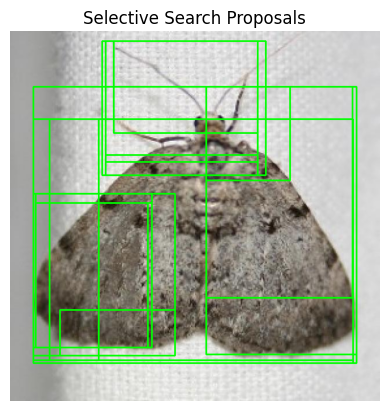

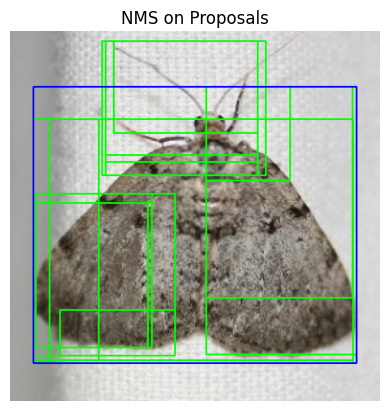

Evaluating class ants @ IoU_THRESHOLD=0.1: 100%|██████████| 54/54 [00:12<00:00,  4.38it/s]


TP: 11, FP: 16, FN: 78, Precision: 0.4074, Recall: 0.1236 @ IoU_THRESHOLD=0.1


Evaluating class ants @ IoU_THRESHOLD=0.3: 100%|██████████| 54/54 [00:12<00:00,  4.40it/s]


TP: 4, FP: 23, FN: 83, Precision: 0.1481, Recall: 0.0460 @ IoU_THRESHOLD=0.3


Evaluating class ants @ IoU_THRESHOLD=0.5: 100%|██████████| 54/54 [00:12<00:00,  4.43it/s]


TP: 1, FP: 26, FN: 86, Precision: 0.0370, Recall: 0.0115 @ IoU_THRESHOLD=0.5


Evaluating class ants @ IoU_THRESHOLD=0.7: 100%|██████████| 54/54 [00:12<00:00,  4.34it/s]


TP: 0, FP: 27, FN: 87, Precision: 0.0000, Recall: 0.0000 @ IoU_THRESHOLD=0.7


Evaluating class ants @ IoU_THRESHOLD=0.9: 100%|██████████| 54/54 [00:12<00:00,  4.34it/s]


TP: 0, FP: 27, FN: 87, Precision: 0.0000, Recall: 0.0000 @ IoU_THRESHOLD=0.9
AP for class ants: 0.0250, missmatch count: 0


Evaluating class bees @ IoU_THRESHOLD=0.1: 100%|██████████| 41/41 [00:05<00:00,  7.92it/s]


TP: 6, FP: 8, FN: 41, Precision: 0.4286, Recall: 0.1277 @ IoU_THRESHOLD=0.1


Evaluating class bees @ IoU_THRESHOLD=0.3: 100%|██████████| 41/41 [00:05<00:00,  7.95it/s]


TP: 3, FP: 11, FN: 42, Precision: 0.2143, Recall: 0.0667 @ IoU_THRESHOLD=0.3


Evaluating class bees @ IoU_THRESHOLD=0.5: 100%|██████████| 41/41 [00:05<00:00,  7.99it/s]


TP: 0, FP: 14, FN: 45, Precision: 0.0000, Recall: 0.0000 @ IoU_THRESHOLD=0.5


Evaluating class bees @ IoU_THRESHOLD=0.7: 100%|██████████| 41/41 [00:05<00:00,  8.00it/s]


TP: 0, FP: 14, FN: 45, Precision: 0.0000, Recall: 0.0000 @ IoU_THRESHOLD=0.7


Evaluating class bees @ IoU_THRESHOLD=0.9: 100%|██████████| 41/41 [00:05<00:00,  8.09it/s]


TP: 0, FP: 14, FN: 45, Precision: 0.0000, Recall: 0.0000 @ IoU_THRESHOLD=0.9
AP for class bees: 0.0267, missmatch count: 0


Evaluating class beetle @ IoU_THRESHOLD=0.1: 100%|██████████| 40/40 [00:00<00:00, 42.38it/s]


TP: 0, FP: 0, FN: 43, Precision: 0.0000, Recall: 0.0000 @ IoU_THRESHOLD=0.1


Evaluating class beetle @ IoU_THRESHOLD=0.3: 100%|██████████| 40/40 [00:00<00:00, 43.04it/s]


TP: 0, FP: 0, FN: 43, Precision: 0.0000, Recall: 0.0000 @ IoU_THRESHOLD=0.3


Evaluating class beetle @ IoU_THRESHOLD=0.5: 100%|██████████| 40/40 [00:00<00:00, 43.47it/s]


TP: 0, FP: 0, FN: 43, Precision: 0.0000, Recall: 0.0000 @ IoU_THRESHOLD=0.5


Evaluating class beetle @ IoU_THRESHOLD=0.7: 100%|██████████| 40/40 [00:00<00:00, 42.60it/s]


TP: 0, FP: 0, FN: 43, Precision: 0.0000, Recall: 0.0000 @ IoU_THRESHOLD=0.7


Evaluating class beetle @ IoU_THRESHOLD=0.9: 100%|██████████| 40/40 [00:00<00:00, 44.05it/s]


TP: 0, FP: 0, FN: 43, Precision: 0.0000, Recall: 0.0000 @ IoU_THRESHOLD=0.9
AP for class beetle: 0.0000, missmatch count: 0


Evaluating class catterpillar @ IoU_THRESHOLD=0.1: 100%|██████████| 48/48 [00:01<00:00, 24.48it/s]


TP: 1, FP: 2, FN: 94, Precision: 0.3333, Recall: 0.0105 @ IoU_THRESHOLD=0.1


Evaluating class catterpillar @ IoU_THRESHOLD=0.3: 100%|██████████| 48/48 [00:01<00:00, 24.69it/s]


TP: 1, FP: 2, FN: 94, Precision: 0.3333, Recall: 0.0105 @ IoU_THRESHOLD=0.3


Evaluating class catterpillar @ IoU_THRESHOLD=0.5: 100%|██████████| 48/48 [00:01<00:00, 24.54it/s]


TP: 0, FP: 3, FN: 95, Precision: 0.0000, Recall: 0.0000 @ IoU_THRESHOLD=0.5


Evaluating class catterpillar @ IoU_THRESHOLD=0.7: 100%|██████████| 48/48 [00:01<00:00, 24.56it/s]


TP: 0, FP: 3, FN: 95, Precision: 0.0000, Recall: 0.0000 @ IoU_THRESHOLD=0.7


Evaluating class catterpillar @ IoU_THRESHOLD=0.9: 100%|██████████| 48/48 [00:01<00:00, 24.60it/s]


TP: 0, FP: 3, FN: 95, Precision: 0.0000, Recall: 0.0000 @ IoU_THRESHOLD=0.9
AP for class catterpillar: 0.0018, missmatch count: 0


Evaluating class earthworms @ IoU_THRESHOLD=0.1: 100%|██████████| 27/27 [00:07<00:00,  3.45it/s]


TP: 5, FP: 10, FN: 36, Precision: 0.3333, Recall: 0.1220 @ IoU_THRESHOLD=0.1


Evaluating class earthworms @ IoU_THRESHOLD=0.3: 100%|██████████| 27/27 [00:07<00:00,  3.40it/s]


TP: 0, FP: 15, FN: 40, Precision: 0.0000, Recall: 0.0000 @ IoU_THRESHOLD=0.3


Evaluating class earthworms @ IoU_THRESHOLD=0.5: 100%|██████████| 27/27 [00:07<00:00,  3.46it/s]


TP: 0, FP: 15, FN: 40, Precision: 0.0000, Recall: 0.0000 @ IoU_THRESHOLD=0.5


Evaluating class earthworms @ IoU_THRESHOLD=0.7: 100%|██████████| 27/27 [00:07<00:00,  3.49it/s]


TP: 0, FP: 15, FN: 40, Precision: 0.0000, Recall: 0.0000 @ IoU_THRESHOLD=0.7


Evaluating class earthworms @ IoU_THRESHOLD=0.9: 100%|██████████| 27/27 [00:07<00:00,  3.47it/s]


TP: 0, FP: 15, FN: 40, Precision: 0.0000, Recall: 0.0000 @ IoU_THRESHOLD=0.9
AP for class earthworms: 0.0203, missmatch count: 0


Evaluating class earwig @ IoU_THRESHOLD=0.1: 100%|██████████| 59/59 [00:01<00:00, 43.05it/s]


TP: 0, FP: 0, FN: 73, Precision: 0.0000, Recall: 0.0000 @ IoU_THRESHOLD=0.1


Evaluating class earwig @ IoU_THRESHOLD=0.3: 100%|██████████| 59/59 [00:01<00:00, 43.83it/s]


TP: 0, FP: 0, FN: 73, Precision: 0.0000, Recall: 0.0000 @ IoU_THRESHOLD=0.3


Evaluating class earwig @ IoU_THRESHOLD=0.5: 100%|██████████| 59/59 [00:01<00:00, 42.83it/s]


TP: 0, FP: 0, FN: 73, Precision: 0.0000, Recall: 0.0000 @ IoU_THRESHOLD=0.5


Evaluating class earwig @ IoU_THRESHOLD=0.7: 100%|██████████| 59/59 [00:01<00:00, 43.66it/s]


TP: 0, FP: 0, FN: 73, Precision: 0.0000, Recall: 0.0000 @ IoU_THRESHOLD=0.7


Evaluating class earwig @ IoU_THRESHOLD=0.9: 100%|██████████| 59/59 [00:01<00:00, 43.49it/s]


TP: 0, FP: 0, FN: 73, Precision: 0.0000, Recall: 0.0000 @ IoU_THRESHOLD=0.9
AP for class earwig: 0.0000, missmatch count: 0


Evaluating class grasshopper @ IoU_THRESHOLD=0.1: 100%|██████████| 38/38 [00:08<00:00,  4.25it/s]


TP: 10, FP: 17, FN: 47, Precision: 0.3704, Recall: 0.1754 @ IoU_THRESHOLD=0.1


Evaluating class grasshopper @ IoU_THRESHOLD=0.3: 100%|██████████| 38/38 [00:09<00:00,  4.20it/s]


TP: 4, FP: 23, FN: 51, Precision: 0.1481, Recall: 0.0727 @ IoU_THRESHOLD=0.3


Evaluating class grasshopper @ IoU_THRESHOLD=0.5: 100%|██████████| 38/38 [00:10<00:00,  3.78it/s]


TP: 3, FP: 24, FN: 52, Precision: 0.1111, Recall: 0.0545 @ IoU_THRESHOLD=0.5


Evaluating class grasshopper @ IoU_THRESHOLD=0.7: 100%|██████████| 38/38 [00:09<00:00,  4.19it/s]


TP: 0, FP: 27, FN: 55, Precision: 0.0000, Recall: 0.0000 @ IoU_THRESHOLD=0.7


Evaluating class grasshopper @ IoU_THRESHOLD=0.9: 100%|██████████| 38/38 [00:08<00:00,  4.34it/s]


TP: 0, FP: 27, FN: 55, Precision: 0.0000, Recall: 0.0000 @ IoU_THRESHOLD=0.9
AP for class grasshopper: 0.0320, missmatch count: 0


Evaluating class moth @ IoU_THRESHOLD=0.1: 100%|██████████| 45/45 [00:58<00:00,  1.30s/it]


TP: 35, FP: 40, FN: 17, Precision: 0.4667, Recall: 0.6731 @ IoU_THRESHOLD=0.1


Evaluating class moth @ IoU_THRESHOLD=0.3: 100%|██████████| 45/45 [00:58<00:00,  1.30s/it]


TP: 20, FP: 55, FN: 25, Precision: 0.2667, Recall: 0.4444 @ IoU_THRESHOLD=0.3


Evaluating class moth @ IoU_THRESHOLD=0.5: 100%|██████████| 45/45 [00:59<00:00,  1.31s/it]


TP: 16, FP: 59, FN: 29, Precision: 0.2133, Recall: 0.3556 @ IoU_THRESHOLD=0.5


Evaluating class moth @ IoU_THRESHOLD=0.7: 100%|██████████| 45/45 [00:58<00:00,  1.30s/it]


TP: 14, FP: 61, FN: 31, Precision: 0.1867, Recall: 0.3111 @ IoU_THRESHOLD=0.7


Evaluating class moth @ IoU_THRESHOLD=0.9: 100%|██████████| 45/45 [00:59<00:00,  1.32s/it]


TP: 4, FP: 71, FN: 41, Precision: 0.0533, Recall: 0.0889 @ IoU_THRESHOLD=0.9
AP for class moth: 0.1407, missmatch count: 0


Evaluating class slug @ IoU_THRESHOLD=0.1: 100%|██████████| 46/46 [00:09<00:00,  4.88it/s]


TP: 4, FP: 10, FN: 48, Precision: 0.2857, Recall: 0.0769 @ IoU_THRESHOLD=0.1


Evaluating class slug @ IoU_THRESHOLD=0.3: 100%|██████████| 46/46 [00:09<00:00,  4.97it/s]


TP: 2, FP: 12, FN: 49, Precision: 0.1429, Recall: 0.0392 @ IoU_THRESHOLD=0.3


Evaluating class slug @ IoU_THRESHOLD=0.5: 100%|██████████| 46/46 [00:09<00:00,  4.99it/s]


TP: 1, FP: 13, FN: 50, Precision: 0.0714, Recall: 0.0196 @ IoU_THRESHOLD=0.5


Evaluating class slug @ IoU_THRESHOLD=0.7: 100%|██████████| 46/46 [00:09<00:00,  4.97it/s]


TP: 0, FP: 14, FN: 51, Precision: 0.0000, Recall: 0.0000 @ IoU_THRESHOLD=0.7


Evaluating class slug @ IoU_THRESHOLD=0.9: 100%|██████████| 46/46 [00:09<00:00,  5.02it/s]


TP: 0, FP: 14, FN: 51, Precision: 0.0000, Recall: 0.0000 @ IoU_THRESHOLD=0.9
AP for class slug: 0.0109, missmatch count: 0


Evaluating class snail @ IoU_THRESHOLD=0.1: 100%|██████████| 44/44 [00:35<00:00,  1.22it/s]


TP: 30, FP: 65, FN: 26, Precision: 0.3158, Recall: 0.5357 @ IoU_THRESHOLD=0.1


Evaluating class snail @ IoU_THRESHOLD=0.3: 100%|██████████| 44/44 [00:36<00:00,  1.21it/s]


TP: 14, FP: 81, FN: 36, Precision: 0.1474, Recall: 0.2800 @ IoU_THRESHOLD=0.3


Evaluating class snail @ IoU_THRESHOLD=0.5: 100%|██████████| 44/44 [00:36<00:00,  1.20it/s]


TP: 5, FP: 90, FN: 45, Precision: 0.0526, Recall: 0.1000 @ IoU_THRESHOLD=0.5


Evaluating class snail @ IoU_THRESHOLD=0.7: 100%|██████████| 44/44 [00:36<00:00,  1.21it/s]


TP: 1, FP: 94, FN: 49, Precision: 0.0105, Recall: 0.0200 @ IoU_THRESHOLD=0.7


Evaluating class snail @ IoU_THRESHOLD=0.9: 100%|██████████| 44/44 [00:36<00:00,  1.20it/s]


TP: 0, FP: 95, FN: 50, Precision: 0.0000, Recall: 0.0000 @ IoU_THRESHOLD=0.9
AP for class snail: 0.0798, missmatch count: 0


Evaluating class wasp @ IoU_THRESHOLD=0.1: 100%|██████████| 46/46 [00:15<00:00,  3.02it/s]


TP: 14, FP: 21, FN: 34, Precision: 0.4000, Recall: 0.2917 @ IoU_THRESHOLD=0.1


Evaluating class wasp @ IoU_THRESHOLD=0.3: 100%|██████████| 46/46 [00:14<00:00,  3.08it/s]


TP: 8, FP: 27, FN: 39, Precision: 0.2286, Recall: 0.1702 @ IoU_THRESHOLD=0.3


Evaluating class wasp @ IoU_THRESHOLD=0.5: 100%|██████████| 46/46 [00:15<00:00,  3.03it/s]


TP: 5, FP: 30, FN: 42, Precision: 0.1429, Recall: 0.1064 @ IoU_THRESHOLD=0.5


Evaluating class wasp @ IoU_THRESHOLD=0.7: 100%|██████████| 46/46 [00:14<00:00,  3.07it/s]


TP: 2, FP: 33, FN: 45, Precision: 0.0571, Recall: 0.0426 @ IoU_THRESHOLD=0.7


Evaluating class wasp @ IoU_THRESHOLD=0.9: 100%|██████████| 46/46 [00:14<00:00,  3.07it/s]


TP: 1, FP: 34, FN: 46, Precision: 0.0286, Recall: 0.0213 @ IoU_THRESHOLD=0.9
AP for class wasp: 0.0573, missmatch count: 0


Evaluating class Weevil @ IoU_THRESHOLD=0.1: 100%|██████████| 58/58 [00:22<00:00,  2.63it/s]


TP: 13, FP: 26, FN: 45, Precision: 0.3333, Recall: 0.2241 @ IoU_THRESHOLD=0.1


Evaluating class Weevil @ IoU_THRESHOLD=0.3: 100%|██████████| 58/58 [00:21<00:00,  2.65it/s]


TP: 11, FP: 28, FN: 47, Precision: 0.2821, Recall: 0.1897 @ IoU_THRESHOLD=0.3


Evaluating class Weevil @ IoU_THRESHOLD=0.5: 100%|██████████| 58/58 [00:21<00:00,  2.65it/s]


TP: 9, FP: 30, FN: 49, Precision: 0.2308, Recall: 0.1552 @ IoU_THRESHOLD=0.5


Evaluating class Weevil @ IoU_THRESHOLD=0.7: 100%|██████████| 58/58 [00:21<00:00,  2.64it/s]


TP: 8, FP: 31, FN: 50, Precision: 0.2051, Recall: 0.1379 @ IoU_THRESHOLD=0.7


Evaluating class Weevil @ IoU_THRESHOLD=0.9: 100%|██████████| 58/58 [00:21<00:00,  2.65it/s]

TP: 2, FP: 37, FN: 56, Precision: 0.0513, Recall: 0.0345 @ IoU_THRESHOLD=0.9
AP for class Weevil: 0.0365, missmatch count: 0
mAP over 12 classes: 0.0359


In [71]:
# Selective Search with NMS and Evaluation of detection on test set
import random
import selectivesearch
import matplotlib.pyplot as plt

# Load trained models
model_data_whole = joblib.load("svm_ovr_model_whole.pkl")
svm_models_whole = model_data_whole["models"]
scaler_whole = model_data_whole["scaler"]
class_names = model_data_whole["class_names"]

model_data_insect = joblib.load("svm_ovr_model_insect.pkl")
svm_models_insect = model_data_insect["models"]
scaler_insect = model_data_insect["scaler"]

TEST_IMG_DIR = os.path.join(BASE_PATH, "test", "images")
TEST_LBL_DIR = os.path.join(BASE_PATH, "test", "labels")

def detect(test_img=None, show_plots=True, IoU_THRESHOLD=0.5):
    test_img_path = os.path.join(TEST_IMG_DIR, test_img)
    test_lbl_path = os.path.join(TEST_LBL_DIR, os.path.splitext(test_img)[0] + ".txt")
    img = cv2.imread(test_img_path)
    img_h, img_w = img.shape[:2]

    # predict the class of the whole image
    resized = cv2.resize(img, HOG_WINDOW_SIZE)
    gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
    feat = HOG.compute(gray).flatten().reshape(1, -1)
    feat_scaled = scaler_whole.transform(feat)
    probs = np.array([clf.predict_proba(feat_scaled)[0][1] for clf in svm_models_whole]).flatten()
    pred_cls = int(np.argmax(probs))
    if show_plots:
        # print the name of the predicted class
        print(f"Predicted class for the image: {class_names[pred_cls]} (prob: {np.max(probs)})")

    # load ground truth boxes
    gt_boxes = []
    with open(test_lbl_path, "r") as f:
        for line in f:
            parts = line.strip().split()
            if not parts:
                continue
            class_id = int(parts[0])
            bbox = [float(x) for x in parts[1:5]]
            x1, y1, x2, y2 = convert_yolo_to_pixels(bbox, img_w, img_h)
            gt_boxes.append((x1, y1, x2, y2, class_id))

    # If not correct class, skip detection and return number of GT boxes as FN
    if pred_cls != int(open(test_lbl_path).readline().strip().split()[0]):
        return 0, 0, len(gt_boxes)

    # selective search on the image (dropping the biggest region which is the whole image)
    img_lbl, regions = selectivesearch.selective_search(img, scale=500, sigma=0.9, min_size=10)
    proposals = []
    MAX_DIM_THRESHOLD = 0.98
    for r in regions:
        x, y, w, h = r['rect']
        if w > img_w * MAX_DIM_THRESHOLD:
            continue
        if h > img_h * MAX_DIM_THRESHOLD:
            continue
        if r['rect'] in proposals:
            continue
        if r['size'] < 2000:
            continue
        x, y, w, h = r['rect']
        if w < 20 or h < 20:
            continue
        proposals.append(r['rect'])

    if show_plots:
        # plot the image with proposals
        for (x, y, w, h) in proposals:
            cv2.rectangle(img, (int(x), int(y)), (int(x + w), int(y + h)), (0, 255, 0), 2)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis("off")
        plt.title("Selective Search Proposals")
        plt.show()

    # NMS for the image proposals
    y_scores = []
    for (x, y, w, h) in proposals:
        cropped = img[y:y + h, x:x + w]
        resized = cv2.resize(cropped, HOG_WINDOW_SIZE)
        gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
        feat = HOG.compute(gray).flatten().reshape(1, -1)
        feat_scaled = scaler_insect.transform(feat)
        prob = svm_models_insect[pred_cls].predict_proba(feat_scaled)[0][1]
        y_scores.append(prob)
    boxes = np.array([[x, y, x + w, y + h] for (x, y, w, h) in proposals])
    pick = non_max_suppression(boxes, probs=y_scores, overlapThresh=0.01)

    if show_plots:
        # plot the image with NMS proposals
        img_nms = img.copy()
        for (x1, y1, x2, y2) in pick:
            cv2.rectangle(img_nms, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 2)
        plt.imshow(cv2.cvtColor(img_nms, cv2.COLOR_BGR2RGB))
        plt.axis("off")
        plt.title("NMS on Proposals")
        plt.show()

    # determine TP, FP, FN
    # compute IoU for each predicted box with each ground truth box
    tp = 0
    fp = 0
    fn = 0
    for (x1, y1, x2, y2) in pick:
        matched = False
        for (gx1, gy1, gx2, gy2, gclass) in gt_boxes:
            # compute IoU
            ix1 = max(x1, gx1)
            iy1 = max(y1, gy1)
            ix2 = min(x2, gx2)
            iy2 = min(y2, gy2)
            iw = max(0, ix2 - ix1)
            ih = max(0, iy2 - iy1)
            inter_area = iw * ih
            box_area = (x2 - x1) * (y2 - y1)
            gt_box_area = (gx2 - gx1) * (gy2 - gy1)
            union_area = box_area + gt_box_area - inter_area
            iou = inter_area / union_area if union_area > 0 else 0
            if iou >= IoU_THRESHOLD:
                matched = True
                break
        if matched:
            tp += 1
        else:
            fp += 1
    fn = max(len(gt_boxes) - tp, 0)

    return tp, fp, fn

# show example detection
result = detect("moth-43-_jpg.rf.151ca77c476f95158198c48caeb8e12d.jpg")

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Evaluation of detection on test set (calculating mAP for 12 classes)
APs = [] # list of AP for each class (12 elements in total)
for class_idx in range(NUM_CLASSES):
    test_img_files = [f for f in os.listdir(TEST_IMG_DIR) if f.lower().endswith(('.jpg', '.png', '.jpeg')) and f.startswith(f"{class_names[class_idx]}")]
    # AP (5-point interpolation)
    curve_points = []
    for IoU_THRESHOLD in [0.1, 0.3, 0.5, 0.7, 0.9]:
        tp_total = 0
        fp_total = 0
        fn_total = 0
        for test_img in tqdm(test_img_files, desc=f"Evaluating class {class_names[class_idx]} @ IoU_THRESHOLD={IoU_THRESHOLD}"):
            missmatch_count = 0
            result = detect(test_img, show_plots=False, IoU_THRESHOLD=IoU_THRESHOLD)
            if result:
                tp, fp, fn = result
                tp_total += tp
                fp_total += fp
                fn_total += fn
            else:
                missmatch_count += 1
        precision = tp_total / (tp_total + fp_total) if (tp_total + fp_total) > 0 else 0
        recall = tp_total / (tp_total + fn_total) if (tp_total + fn_total) > 0 else 0
        print(f"TP: {tp_total}, FP: {fp_total}, FN: {fn_total}, Precision: {precision:.4f}, Recall: {recall:.4f} @ IoU_THRESHOLD={IoU_THRESHOLD}")
        curve_points.append((recall, precision))
    # sort curve points by recall
    curve_points = sorted(curve_points, key=lambda x: x[0])
    # calculate AP from curve_points (integration)
    AP = 0
    for i in range(1, len(curve_points)):
        r1, p1 = curve_points[i - 1]
        r2, p2 = curve_points[i]
        AP += (r2 - r1) * (p1 + p2) / 2
    APs.append(AP)
    print(f"AP for class {class_names[class_idx]}: {AP:.4f}, missmatch count: {missmatch_count}")

print(f"mAP over {NUM_CLASSES} classes: {np.mean(APs):.4f}")

In [70]:
# Evaluation of classification performance on test set

from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, confusion_matrix, classification_report
from sklearn.preprocessing import label_binarize

# Evaluate using ground-truth bboxes from the test set.
TEST_IMG_DIR = os.path.join(BASE_PATH, "test", "images")
TEST_LBL_DIR = os.path.join(BASE_PATH, "test", "labels")
model_path = "svm_ovr_model_whole.pkl"

# Load model (reuse if already in memory)
model_data = joblib.load(model_path)
svm_models = model_data["models"]
scaler = model_data["scaler"]
class_names = model_data.get("class_names", CLASS_NAMES)

y_true = []
y_pred = []
y_scores = []  # per-sample probability vector for all classes

test_img_files = [f for f in os.listdir(TEST_IMG_DIR) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]

for img_file in tqdm(test_img_files, desc="Evaluating on test set"):
    img_path = os.path.join(TEST_IMG_DIR, img_file)
    lbl_path = os.path.join(TEST_LBL_DIR, os.path.splitext(img_file)[0] + ".txt")
    img = cv2.imread(img_path)
    if img is None or not os.path.exists(lbl_path):
        continue

    img_h, img_w = img.shape[:2]
    with open(lbl_path, "r") as f_lbl:
        for line in f_lbl:
            parts = line.strip().split()
            if not parts:
                continue
            true_cls = int(parts[0])
            bbox = [float(x) for x in parts[1:5]]
            x1, y1, x2, y2 = convert_yolo_to_pixels(bbox, img_w, img_h)
            cropped = img[y1:y2, x1:x2]
            if cropped.size == 0:
                continue

            # Preprocess exactly as during training
            resized = cv2.resize(cropped, HOG_WINDOW_SIZE)
            gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
            feat = HOG.compute(gray).flatten().reshape(1, -1)
            feat_scaled = scaler.transform(feat)

            # Get probability for the positive class from each one-vs-rest classifier
            probs = np.array([clf.predict_proba(feat_scaled)[0][1] for clf in svm_models]).flatten()
            pred_cls = int(np.argmax(probs))
            
            y_true.append(true_cls)
            y_pred.append(pred_cls)
            y_scores.append(probs)

# Convert lists to arrays
if len(y_true) == 0:
    print("No labeled test samples found.")
else:
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_scores = np.vstack(y_scores)  # shape (n_samples, n_classes)

    # Precision, recall, f1 per class and macro averages
    p_r_f1_per_class = precision_recall_fscore_support(y_true, y_pred, labels=list(range(NUM_CLASSES)), zero_division=0)
    precision_per_class, recall_per_class, f1_per_class, support_per_class = p_r_f1_per_class
    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(y_true, y_pred, average='macro', zero_division=0)

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=list(range(NUM_CLASSES)))

    # AUC (One-vs-Rest). Binarize true labels
    y_true_bin = label_binarize(y_true, classes=list(range(NUM_CLASSES)))
    try:
        auc_macro = roc_auc_score(y_true_bin, y_scores, average='macro', multi_class='ovr')
        auc_per_class = []
        for i in range(NUM_CLASSES):
            try:
                auc_i = roc_auc_score(y_true_bin[:, i], y_scores[:, i])
            except Exception:
                auc_i = np.nan
            auc_per_class.append(auc_i)
        auc_per_class = np.array(auc_per_class)
    except Exception as e:
        auc_macro = np.nan
        auc_per_class = np.array([np.nan] * NUM_CLASSES)
        print("Warning: AUC could not be computed (maybe some classes are missing in test set).", str(e))

    # Print summary
    print("Macro Precision: {:.4f}, Macro Recall: {:.4f}, Macro F1: {:.4f}".format(precision_macro, recall_macro, f1_macro))
    print("AUC (macro, OvR): {:.4f}".format(auc_macro if not np.isnan(auc_macro) else float("nan")))
    print("\nPer-class metrics:")
    for idx in range(NUM_CLASSES):
        print(f"{idx:02d} {class_names[idx]:12s} | P: {precision_per_class[idx]:.4f} R: {recall_per_class[idx]:.4f} F1: {f1_per_class[idx]:.4f} AUC: {auc_per_class[idx] if not np.isnan(auc_per_class[idx]) else 'nan'} S: {support_per_class[idx]}")

    print("\nConfusion Matrix (rows=true, cols=pred):")
    print(cm)

    print("\nFull classification report:")
    print(classification_report(y_true, y_pred, labels=list(range(NUM_CLASSES)), target_names=class_names, zero_division=0, digits=4))

Evaluating on test set: 100%|██████████| 546/546 [00:16<00:00, 33.51it/s]

Macro Precision: 0.1742, Macro Recall: 0.1712, Macro F1: 0.1283
AUC (macro, OvR): 0.6211

Per-class metrics:
00 ants         | P: 0.1500 R: 0.0345 F1: 0.0561 AUC: 0.6215870470080574 S: 87
01 bees         | P: 0.0758 R: 0.1136 F1: 0.0909 AUC: 0.5032064834390416 S: 44
02 beetle       | P: 0.0000 R: 0.0000 F1: 0.0000 AUC: 0.5508809020436928 S: 44
03 catterpillar | P: 0.4615 R: 0.0645 F1: 0.1132 AUC: 0.5229486901926824 S: 93
04 earthworms   | P: 0.0566 R: 0.0750 F1: 0.0645 AUC: 0.6186055469953775 S: 40
05 earwig       | P: 0.3333 R: 0.0137 F1: 0.0263 AUC: 0.5048701298701298 S: 73
06 grasshopper  | P: 0.1461 R: 0.2364 F1: 0.1806 AUC: 0.580613708058503 S: 55
07 moth         | P: 0.2000 R: 0.4681 F1: 0.2803 AUC: 0.772453105322463 S: 47
08 slug         | P: 0.1071 R: 0.1176 F1: 0.1121 AUC: 0.6227795193312434 S: 51
09 snail        | P: 0.1518 R: 0.5800 F1: 0.2407 AUC: 0.7162441314553991 S: 50
10 wasp         | P: 0.2128 R: 0.2128 F1: 0.2128 AUC: 0.7255252866706436 S: 47
11 Weevil       | P: 0.1